In [1]:
## data analysis in python
# importing packs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# loading generated csvs
budget_df = pd.read_csv("budget.csv", parse_dates=["month"])
actuals_df = pd.read_csv("actuals.csv", parse_dates=["month"])

# printing head of dfs
print("BUDGET", budget_df.head())
print("ACTUALS", actuals_df.head())

BUDGET        month department  budget_revenue  budget_expenses
0 2025-01-01      Sales       209934.28        147926.04
1 2025-02-01      Sales       212953.77        172845.45
2 2025-03-01      Sales       195316.93        146487.95
3 2025-04-01      Sales       231584.26        161511.52
4 2025-05-01      Sales       190610.51        158138.40
ACTUALS        month department  actual_revenue  actual_expenses
0 2025-01-01      Sales       224775.80        138631.03
1 2025-02-01      Sales       240069.86        129766.68
2 2025-03-01      Sales       219671.43        194428.20
3 2025-04-01      Sales       180236.59        144806.64
4 2025-05-01      Sales       207491.28        145937.44


In [3]:
# computing forecast using linear regression
from scipy.stats import linregress

# recreate departments or business units
departments = ["Sales", "Marketing", "R&D", "Operations", "HR"]

def calculate_moving_average(df, department):
    # filtering by department
    dept_df = actuals_df[actuals_df['department'] == department].copy()
    
    # calculate moving average for revenue and expenses
    dept_df['revenue_ma3'] = dept_df['actual_revenue'].rolling(window=3).mean()
    dept_df['expenses_ma3'] = dept_df['actual_expenses'].rolling(window=3).mean()
    
    return dept_df

def calculate_trend(series):
    """Calculates the linear trend for the last 6 months"""
    if len(series) >= 6:
        last_6 = series[-6:]
        x = np.arange(len(last_6))
        slope, _, _, _, _ = linregress(x, last_6)
        return slope / np.mean(last_6)  # returns the slope as a percentage of the average
    return 0

# adding seasonality to a better accuracy
def add_seasonality(month_num, values, seasonal_pattern):
    """Adds seasonal component based on historical patterns"""
    season_factor = seasonal_pattern.get(month_num, 1)
    return values * season_factor

# defining a seasonal pattern
seasonal_pattern = {
    1: 1.05,  # january is typically 5% over the average
    2: 0.98,   # february is typically 2% under the avg
    3: 1.02    # march is 2% over the avg
}

# list to store the forecast
forecasts = []

for dept in departments:
    # calculate moving average for the department
    dept_df = calculate_moving_average(actuals_df, dept)
    
    # taking the last values
    last_revenue = dept_df['actual_revenue'].iloc[-3:].mean()
    last_expenses = dept_df['actual_expenses'].iloc[-3:].mean()
    
    # calculate trends
    rev_trend = calculate_trend(dept_df['actual_revenue'].dropna())
    exp_trend = calculate_trend(dept_df['actual_expenses'].dropna())
    
    # create forecasts for the first 3 months in 2026
    for i, month in enumerate(['2026-01-01', '2026-02-01', '2026-03-01']):
        month_num = i + 1
        
        # calculate base forecast with trend
        rev_forecast = last_revenue * (1 + rev_trend * (i+1))
        exp_forecast = last_expenses * (1 + exp_trend * (i+1))
        
        # adding seasonality
        rev_forecast = add_seasonality(month_num, rev_forecast, seasonal_pattern)
        exp_forecast = add_seasonality(month_num, exp_forecast, seasonal_pattern)
        
        # add small random variation (+/-1.5%)
        rev_forecast *= np.random.uniform(0.985, 1.015)
        exp_forecast *= np.random.uniform(0.985, 1.015)
        
        forecasts.append({
            'month': month,
            'department': dept,
            'forecast_revenue': round(rev_forecast, 2),
            'forecast_expenses': round(exp_forecast, 2),
            'revenue_trend': f"{rev_trend*100:.2f}%",
            'expenses_trend': f"{exp_trend*100:.2f}%"
        })

# create dataframe
forecast_df = pd.DataFrame(forecasts)

# printing head
print(forecast_df.head(9))

        month department  forecast_revenue  forecast_expenses revenue_trend  \
0  2026-01-01      Sales         212531.88          162447.42         0.86%   
1  2026-02-01      Sales         199419.94          149464.21         0.86%   
2  2026-03-01      Sales         207154.16          157067.86         0.86%   
3  2026-01-01  Marketing         246311.47          174722.94         1.12%   
4  2026-02-01  Marketing         227423.59          167526.79         1.12%   
5  2026-03-01  Marketing         245475.63          176592.56         1.12%   
6  2026-01-01        R&D         204649.12          159347.64        -1.43%   
7  2026-02-01        R&D         191292.58          151282.75        -1.43%   
8  2026-03-01        R&D         194252.14          156252.19        -1.43%   

  expenses_trend  
0         -0.99%  
1         -0.99%  
2         -0.99%  
3          1.49%  
4          1.49%  
5          1.49%  
6          0.60%  
7          0.60%  
8          0.60%  


In [4]:
# converting column 'month' to same string format as the rest of the dataset
forecast_df['month'] = pd.to_datetime(forecast_df['month']).dt.strftime('%Y-%m')
budget_df['month'] = pd.to_datetime(budget_df['month']).dt.strftime('%Y-%m')
actuals_df['month'] = pd.to_datetime(actuals_df['month']).dt.strftime('%Y-%m')

# checking result
print(forecast_df.head())
print(budget_df.head())
print(actuals_df.head())

     month department  forecast_revenue  forecast_expenses revenue_trend  \
0  2026-01      Sales         212531.88          162447.42         0.86%   
1  2026-02      Sales         199419.94          149464.21         0.86%   
2  2026-03      Sales         207154.16          157067.86         0.86%   
3  2026-01  Marketing         246311.47          174722.94         1.12%   
4  2026-02  Marketing         227423.59          167526.79         1.12%   

  expenses_trend  
0         -0.99%  
1         -0.99%  
2         -0.99%  
3          1.49%  
4          1.49%  
     month department  budget_revenue  budget_expenses
0  2025-01      Sales       209934.28        147926.04
1  2025-02      Sales       212953.77        172845.45
2  2025-03      Sales       195316.93        146487.95
3  2025-04      Sales       231584.26        161511.52
4  2025-05      Sales       190610.51        158138.40
     month department  actual_revenue  actual_expenses
0  2025-01      Sales       224775.80       

In [5]:
# merge budget and actuals into a unique dataframe
combined_budget_actuals_df = budget_df.merge(actuals_df, on=["department", "month"], suffixes=("_budget", "_actual"))

# printing head
combined_budget_actuals_df.head()

,month,department,budget_revenue,budget_expenses,actual_revenue,actual_expenses
0,2025-01,Sales,209934.28,147926.04,224775.80,138631.03
1,2025-02,Sales,212953.77,172845.45,240069.86,129766.68
2,2025-03,Sales,195316.93,146487.95,219671.43,194428.20
3,2025-04,Sales,231584.26,161511.52,180236.59,144806.64
4,2025-05,Sales,190610.51,158138.40,207491.28,145937.44


In [6]:
# calculate variances between actual (revenues & expenses) and budget
combined_budget_actuals_df["actual_vs_budget_revenue"] = combined_budget_actuals_df["actual_revenue"] - combined_budget_actuals_df["budget_revenue"]
combined_budget_actuals_df["actual_vs_budget_expenses"] = combined_budget_actuals_df["actual_expenses"] - combined_budget_actuals_df["budget_expenses"]

combined_budget_actuals_df

,month,department,budget_revenue,budget_expenses,actual_revenue,actual_expenses,actual_vs_budget_revenue,actual_vs_budget_expenses
0,2025-01,Sales,209934.28,147926.04,224775.80,138631.03,14841.52,-9295.01
1,2025-02,Sales,212953.77,172845.45,240069.86,129766.68,27116.09,-43078.77
2,2025-03,Sales,195316.93,146487.95,219671.43,194428.20,24354.50,47940.25
3,2025-04,Sales,231584.26,161511.52,180236.59,144806.64,-51347.67,-16704.88
4,2025-05,Sales,190610.51,158138.40,207491.28,145937.44,16880.77,-12200.96
5,2025-06,Sales,190731.65,143014.05,166233.41,156234.13,-24498.24,13220.08
6,2025-07,Sales,204839.25,121300.80,178442.41,163524.66,-26396.84,42223.86
7,2025-08,Sales,165501.64,141565.69,182014.39,182898.82,16512.75,41333.13
8,2025-09,Sales,179743.38,154713.71,185418.67,149202.89,5675.29,-5510.82
9,2025-10,Sales,181839.52,128815.44,225337.93,132844.44,43498.41,4029.00


In [7]:
# aggregate revenue by month for plotting
monthly_revenue_summary = combined_budget_actuals_df.groupby("month")[["budget_revenue", "actual_revenue"]].sum().reset_index()

monthly_revenue_summary

,month,budget_revenue,actual_revenue
0,2025-01,1011124.89,1031169.88
1,2025-02,944122.95,999103.66
2,2025-03,943199.25,1086562.45
3,2025-04,1035151.05,1032027.90
4,2025-05,965937.07,1007962.09
5,2025-06,1081089.42,1015627.08
6,2025-07,988414.18,1008404.13
7,2025-08,896743.84,940076.20
8,2025-09,1001372.63,989480.55
9,2025-10,976180.68,1154004.62


In [8]:
# aggregate forecast revenue by month for plotting
monthly_forecast_revenue_summary = forecast_df.groupby("month")[["forecast_revenue"]].sum().reset_index()
monthly_forecast_revenue_summary

,month,forecast_revenue
0,2026-01,1103376.27
1,2026-02,1031036.67
2,2026-03,1082070.96


c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


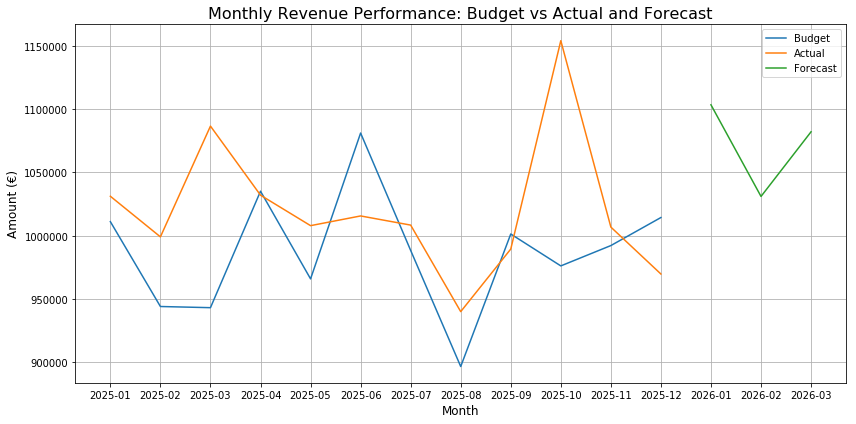

In [9]:
# plot: budget vs actual and forecast over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue_summary["month"], monthly_revenue_summary["budget_revenue"], label="Budget")
plt.plot(monthly_revenue_summary["month"], monthly_revenue_summary["actual_revenue"], label="Actual")
plt.plot(monthly_forecast_revenue_summary["month"], monthly_forecast_revenue_summary["forecast_revenue"], label="Forecast")
plt.title("Monthly Revenue Performance: Budget vs Actual and Forecast", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Amount (€)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
# doing the same analysis for the expenses
# aggregate expenses by month for plotting
monthly_expenses_summary = combined_budget_actuals_df.groupby("month")[["budget_expenses", "actual_expenses"]].sum().reset_index()
monthly_expenses_summary

,month,budget_expenses,actual_expenses
0,2025-01,750529.76,732450.56
1,2025-02,781514.42,719723.31
2,2025-03,740492.89,795070.94
3,2025-04,761417.20,736329.65
4,2025-05,749052.00,825976.85
5,2025-06,734179.20,811907.87
6,2025-07,680477.82,771976.72
7,2025-08,731109.07,836545.68
8,2025-09,822275.47,853842.78
9,2025-10,758404.75,768611.96


In [11]:
# aggregate forecast expenses by month for plotting
monthly_forecast_expenses_summary = forecast_df.groupby("month")[["forecast_expenses"]].sum().reset_index()
monthly_forecast_expenses_summary

,month,forecast_expenses
0,2026-01,849056.78
1,2026-02,803705.14
2,2026-03,846676.71


c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


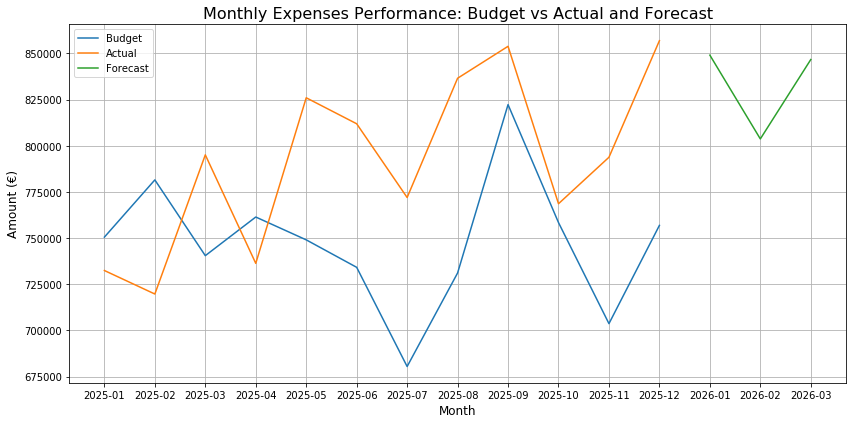

In [12]:
# plot: expenses - budget vs actual and forecast over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_expenses_summary["month"], monthly_expenses_summary["budget_expenses"], label="Budget")
plt.plot(monthly_expenses_summary["month"], monthly_expenses_summary["actual_expenses"], label="Actual")
plt.plot(monthly_forecast_expenses_summary["month"], monthly_forecast_expenses_summary["forecast_expenses"], label="Forecast")
plt.title("Monthly Expenses Performance: Budget vs Actual and Forecast", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Amount (€)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [13]:
# aggregate variation by month for plotting
monthly_variation_summary = combined_budget_actuals_df.groupby("month")[["actual_vs_budget_revenue", "actual_vs_budget_expenses"]].sum().reset_index()
monthly_variation_summary

,month,actual_vs_budget_revenue,actual_vs_budget_expenses
0,2025-01,20044.99,-18079.20
1,2025-02,54980.71,-61791.11
2,2025-03,143363.20,54578.05
3,2025-04,-3123.15,-25087.55
4,2025-05,42025.02,76924.85
5,2025-06,-65462.34,77728.67
6,2025-07,19989.95,91498.90
7,2025-08,43332.36,105436.61
8,2025-09,-11892.08,31567.31
9,2025-10,177823.94,10207.21


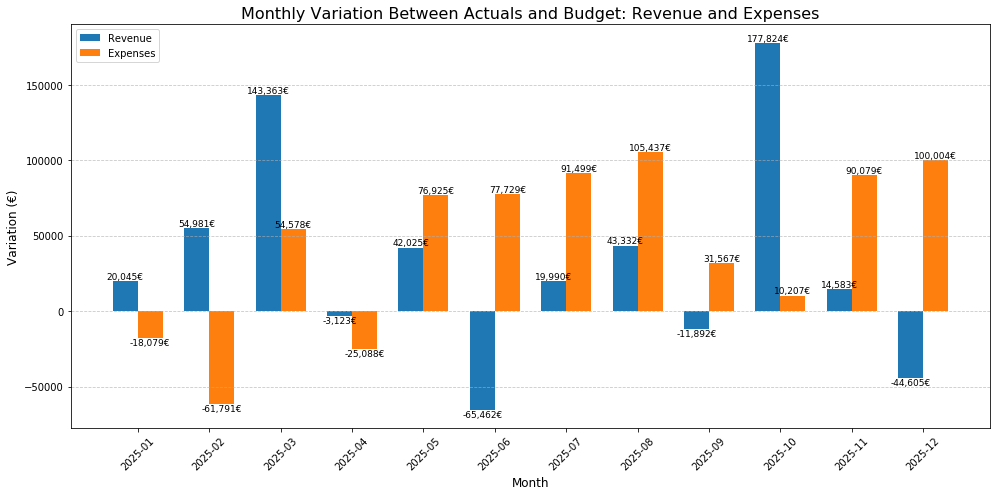

In [14]:
# plot: variation between revenue and expenses over time
plt.figure(figsize=(14, 7))
bars1 = plt.bar(np.arange(len(monthly_variation_summary["month"])) - 0.35/2, monthly_variation_summary["actual_vs_budget_revenue"], 0.35, label='Revenue')
bars2 = plt.bar(np.arange(len(monthly_variation_summary["month"])) + 0.35/2, monthly_variation_summary["actual_vs_budget_expenses"], 0.35, label='Expenses')

# adding values in bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        y_offset = 3 if height >= 0 else -12
        plt.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                 f'{height:,.0f}€',
                 ha='center', va=va, fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)

plt.title('Monthly Variation Between Actuals and Budget: Revenue and Expenses', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Variation (€)', fontsize=12)
plt.xticks(np.arange(len(monthly_variation_summary["month"])), monthly_variation_summary["month"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# calculate monthly profit (revenue - expenses) - using the actual values
monthly_variation_summary['monthly_profit'] = (monthly_revenue_summary['actual_revenue'] - monthly_expenses_summary['actual_expenses'])

# calculate accumulated profit
monthly_variation_summary['cumulative_profit'] = monthly_variation_summary['monthly_profit'].cumsum()

monthly_variation_summary

,month,actual_vs_budget_revenue,actual_vs_budget_expenses,monthly_profit,cumulative_profit
0,2025-01,20044.99,-18079.20,298719.32,298719.32
1,2025-02,54980.71,-61791.11,279380.35,578099.67
2,2025-03,143363.20,54578.05,291491.51,869591.18
3,2025-04,-3123.15,-25087.55,295698.25,1165289.43
4,2025-05,42025.02,76924.85,181985.24,1347274.67
5,2025-06,-65462.34,77728.67,203719.21,1550993.88
6,2025-07,19989.95,91498.90,236427.41,1787421.29
7,2025-08,43332.36,105436.61,103530.52,1890951.81
8,2025-09,-11892.08,31567.31,135637.77,2026589.58
9,2025-10,177823.94,10207.21,385392.66,2411982.24


In [16]:
# create summary table
profit_summary = monthly_variation_summary[['month', 'monthly_profit', 'cumulative_profit']].copy()
profit_summary['monthly_profit'] = profit_summary['monthly_profit'].apply(lambda x: f"€{x:,.2f}")
profit_summary['cumulative_profit'] = profit_summary['cumulative_profit'].apply(lambda x: f"€{x:,.2f}")

total_profit = monthly_variation_summary['monthly_profit'].sum()

print("Monthly Profit Table:")
print(profit_summary.to_string(index=False))
print(f"\nTotal Profit for the Period: €{total_profit:,.2f}")

Monthly Profit Table:
   month monthly_profit cumulative_profit
 2025-01    €298,719.32       €298,719.32
 2025-02    €279,380.35       €578,099.67
 2025-03    €291,491.51       €869,591.18
 2025-04    €295,698.25     €1,165,289.43
 2025-05    €181,985.24     €1,347,274.67
 2025-06    €203,719.21     €1,550,993.88
 2025-07    €236,427.41     €1,787,421.29
 2025-08    €103,530.52     €1,890,951.81
 2025-09    €135,637.77     €2,026,589.58
 2025-10    €385,392.66     €2,411,982.24
 2025-11    €213,049.94     €2,625,032.18
 2025-12    €112,889.05     €2,737,921.23

Total Profit for the Period: €2,737,921.23


In [17]:
# calculate forecast profit by department
forecast_df['forecast_profit'] = forecast_df['forecast_revenue'] - forecast_df['forecast_expenses']

# agregate the forecasts by month, summing all the departments
forecast_summary = forecast_df.groupby('month').agg({
    'forecast_revenue': 'sum',
    'forecast_expenses': 'sum',
    'forecast_profit': 'sum'
}).reset_index()

# convert month to string (same as monthly_variation_summary)
forecast_summary['month'] = pd.to_datetime(forecast_summary['month']).dt.strftime('%Y-%m')

# join with real data in a full summary
full_summary = pd.concat([
    monthly_variation_summary.set_index('month'),
    forecast_summary.set_index('month')
], axis=0).sort_index().reset_index()

# printing the table
print("\nComplete Table with Forecast:")
print(full_summary[['month', 'monthly_profit', 'forecast_profit']].to_string(index=False))



Complete Table with Forecast:
   month  monthly_profit  forecast_profit
 2025-01       298719.32              NaN
 2025-02       279380.35              NaN
 2025-03       291491.51              NaN
 2025-04       295698.25              NaN
 2025-05       181985.24              NaN
 2025-06       203719.21              NaN
 2025-07       236427.41              NaN
 2025-08       103530.52              NaN
 2025-09       135637.77              NaN
 2025-10       385392.66              NaN
 2025-11       213049.94              NaN
 2025-12       112889.05              NaN
 2026-01             NaN        254319.49
 2026-02             NaN        227331.53
 2026-03             NaN        235394.25


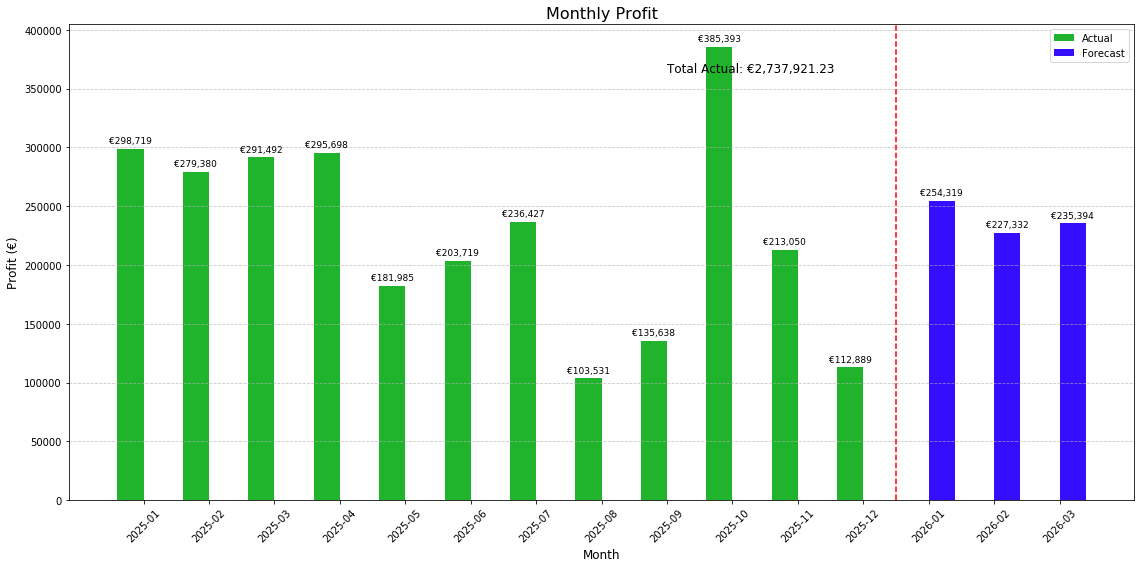

In [18]:
# plotting bar chart of monthly profit with forecast
plt.figure(figsize=(16, 8))

bars_actual = plt.bar(np.arange(len(monthly_variation_summary)) - 0.2, 
        monthly_variation_summary['monthly_profit'], 
        width=0.4, color="#1fb42b", label='Actual')

# plotting forecast
bars_forecast = plt.bar(np.arange(len(forecast_summary)) + len(monthly_variation_summary) + 0.2, 
        forecast_summary['forecast_profit'], 
        width=0.4, color="#360eff", label='Forecast')

# adding a line to separate forecast to real time data and better visualization
plt.axvline(len(monthly_variation_summary)-0.5, color='red', linestyle='--')
plt.title('Monthly Profit', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Profit (€)', fontsize=12)

# joining a list with all months
all_months = list(monthly_variation_summary['month']) + list(forecast_summary['month'])
plt.xticks(np.arange(len(all_months)), all_months, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# adding values to bar chart
total_actual = monthly_variation_summary['monthly_profit'].sum()
total_forecast = forecast_summary['forecast_profit'].sum()
plt.text(len(monthly_variation_summary)-4, max(plt.ylim())*0.9, 
         f'Total Actual: €{total_actual:,.2f}', fontsize=12)

# adding values to actual bars
for bar in bars_actual:
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    y_offset = 3000 if height >= 0 else -8000
    plt.text(bar.get_x() + bar.get_width()/2., height + y_offset,
             f'€{height:,.0f}',
             ha='center', va=va, fontsize=9)

# adding values to forecast bars (novo código adicionado)
for bar in bars_forecast:
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    y_offset = 3000 if height >= 0 else -8000
    plt.text(bar.get_x() + bar.get_width()/2., height + y_offset,
             f'€{height:,.0f}',
             ha='center', va=va, fontsize=9)

plt.tight_layout()
plt.show()

c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\Users\aniel\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


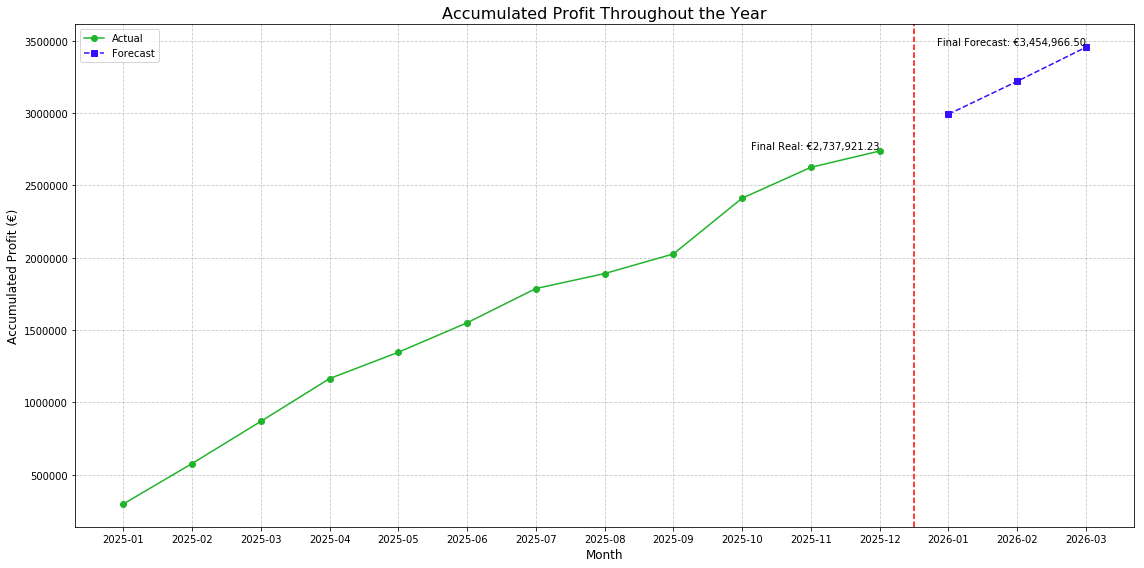

In [19]:
# comparative line chart (cumulative)
plt.figure(figsize=(16, 8))

# calculate cumulative again
monthly_variation_summary['cumulative_real'] = monthly_variation_summary['monthly_profit'].cumsum()
forecast_summary['cumulative_forecast'] = forecast_summary['forecast_profit'].cumsum() + total_actual

# plotting
plt.plot(monthly_variation_summary['month'], 
         monthly_variation_summary['cumulative_real'], 
         'o-', color="#1fb42b", label='Actual')
plt.plot(forecast_summary['month'], 
         forecast_summary['cumulative_forecast'], 
         's--', color="#360eff", label='Forecast')

plt.axvline(len(monthly_variation_summary)-0.5, color='red', linestyle='--')
plt.title('Accumulated Profit Throughout the Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Accumulated Profit (€)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# adding final values
final_real = monthly_variation_summary['cumulative_real'].iloc[-1]
final_forecast = forecast_summary['cumulative_forecast'].iloc[-1]
plt.text(len(monthly_variation_summary)-1, final_real, 
         f'Final Real: €{final_real:,.2f}', ha='right', va='bottom')
plt.text(len(all_months)-1, final_forecast, 
         f'Final Forecast: €{final_forecast:,.2f}', ha='right', va='bottom')

plt.tight_layout()
plt.show()